Ссылка на данные\
https://www.kaggle.com/datasets/alistairking/weather-long-term-time-series-forecasting/data

In [525]:
# import tqdm
# from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.fft import fft, fftfreq

# Расшифровка наименований признаков

В датасете содержатся записи за каждые 10 минут измерений погодных условий в Гейдельберге (Метеостанция института Макса Планка)

| Аббревиатура | Описание |
|--------------|----------|
| date | Дата и время наблюдения. |
| p | Атмосферное давление в миллибарах (mbar). |
| T | Температура воздуха в градусах Цельсия (°C). |
| Tpot | Потенциальная температура в Кельвинах (K) - температура, которую имела бы воздушная масса при перемещении на стандартный уровень давления. |
| Tdew | Температура точки росы в градусах Цельсия (°C) - температура насыщения воздуха влагой. |
| rh | Относительная влажность в процентах (%) - отношение текущей влажности к максимально возможной при данной температуре. |
| VPmax | Максимальное давление водяного пара в миллибарах (mbar) - предельное давление пара при заданной температуре. |
| VPact | Актуальное давление водяного пара в миллибарах (mbar) - текущее давление пара в воздухе. |
| VPdef | Дефицит давления пара в миллибарах (mbar) - разница между VPmax и VPact (показатель потенциала высыхания). |
| sh | Удельная влажность в граммах на килограмм (g/kg) - масса водяного пара на кг воздуха. |
| H2OC | Концентрация водяного пара в миллимолях на моль сухого воздуха (mmol/mol). |
| rho | Плотность воздуха в граммах на кубический метр (g/m³) - масса воздуха на единицу объема. |
| wv | Скорость ветра в метрах в секунду (m/s) - горизонтальное движение воздуха. |
| max.wv | Максимальная скорость ветра в метрах в секунду (m/s) - пиковое значение за период наблюдений. |
| wd | Направление ветра в градусах (°) - направление, откуда дует ветер. |
| rain | Сумма осадков в миллиметрах (mm) - общее количество дождя за период наблюдений. |
| raining | Продолжительность дождя в секундах (s) - время выпадения осадков. |
| SWDR | Коротковолновая нисходящая радиация в ваттах на квадратный метр (W/m²) - входящая солнечная радиация. |
| PAR | Фотосинтетически активная радиация в микромолях на м²/с (µmol/m²/s) - свет, доступный для фотосинтеза. |
| max.PAR | Максимальная фотосинтетически активная радиация за период наблюдений (µmol/m²/s). |
| Tlog | Температура (логированная) в градусах Цельсия (°C) - данные сенсора/логгера. |
| OT | Операционная метка времени (Operational Timestamp) или временное смещение (уточняется в контексте данных). |

# Загрузка датасета

In [526]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('cleaned_weather.csv')

Перевод единиц измерения Кельвинов в Цельсия признака Tpot

In [527]:
df.loc[:,'Tpot'] = df['Tpot'].apply(lambda x: x-273.15)

In [528]:
df.head(6)

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,0.03,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,0.07,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,0.06,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,-0.29,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,-0.33,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
5,2020-01-01 01:00:00,1008.44,0.34,-0.31,-1.54,87.1,6.26,5.45,0.81,3.37,5.41,1281.84,0.63,1.32,188.0,0.0,0.0,0.0,0.0,0.0,11.91


# Описательная статистика данных

Рассмотрение графиков распределения значений записей данных, корреляции признаков. 

In [529]:
df.drop(columns='date').describe()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
count,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000,52696.000000
mean,989.989233,10.818241,11.646938,5.409105,72.487133,14.487046,9.676828,4.810131,6.111159,9.782341,1210.882855,1.995935,3.632807,176.850276,0.011773,25.907469,131.331822,259.863438,308.601939,21.515206
std,9.207149,7.468671,7.616995,5.956722,19.230260,7.632960,4.023504,5.539320,2.561536,4.082684,36.430222,43.596931,2.462467,81.194840,0.123289,111.503420,215.735116,422.786515,569.956762,7.790620
min,955.580000,-6.440000,-6.960000,-13.810000,21.160000,3.770000,2.090000,0.000000,1.300000,2.090000,1107.380000,-9999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9999.000000,6.900000
25%,984.800000,4.590000,5.400000,0.777500,58.820000,8.480000,6.460000,1.170000,4.070000,6.530000,1183.900000,1.000000,1.770000,141.100000,0.000000,0.000000,0.000000,0.000000,0.000000,15.240000
50%,990.920000,10.230000,11.170000,5.260000,75.400000,12.480000,8.890000,2.740000,5.610000,8.990000,1210.800000,1.770000,3.000000,195.500000,0.000000,0.000000,2.820000,9.670000,13.120000,20.440000
75%,995.930000,16.180000,17.110000,9.700000,87.900000,18.420000,12.050000,6.440000,7.620000,12.200000,1236.550000,2.920000,4.850000,226.700000,0.000000,0.000000,182.900000,366.437500,434.260000,26.822500
max,1020.070000,34.800000,35.980000,20.500000,100.000000,55.670000,24.160000,42.100000,15.400000,24.530000,1318.520000,13.770000,22.900000,360.000000,11.200000,600.000000,1115.290000,2131.760000,2498.940000,49.090000


Построение гистограмм для всех числовых столбцов

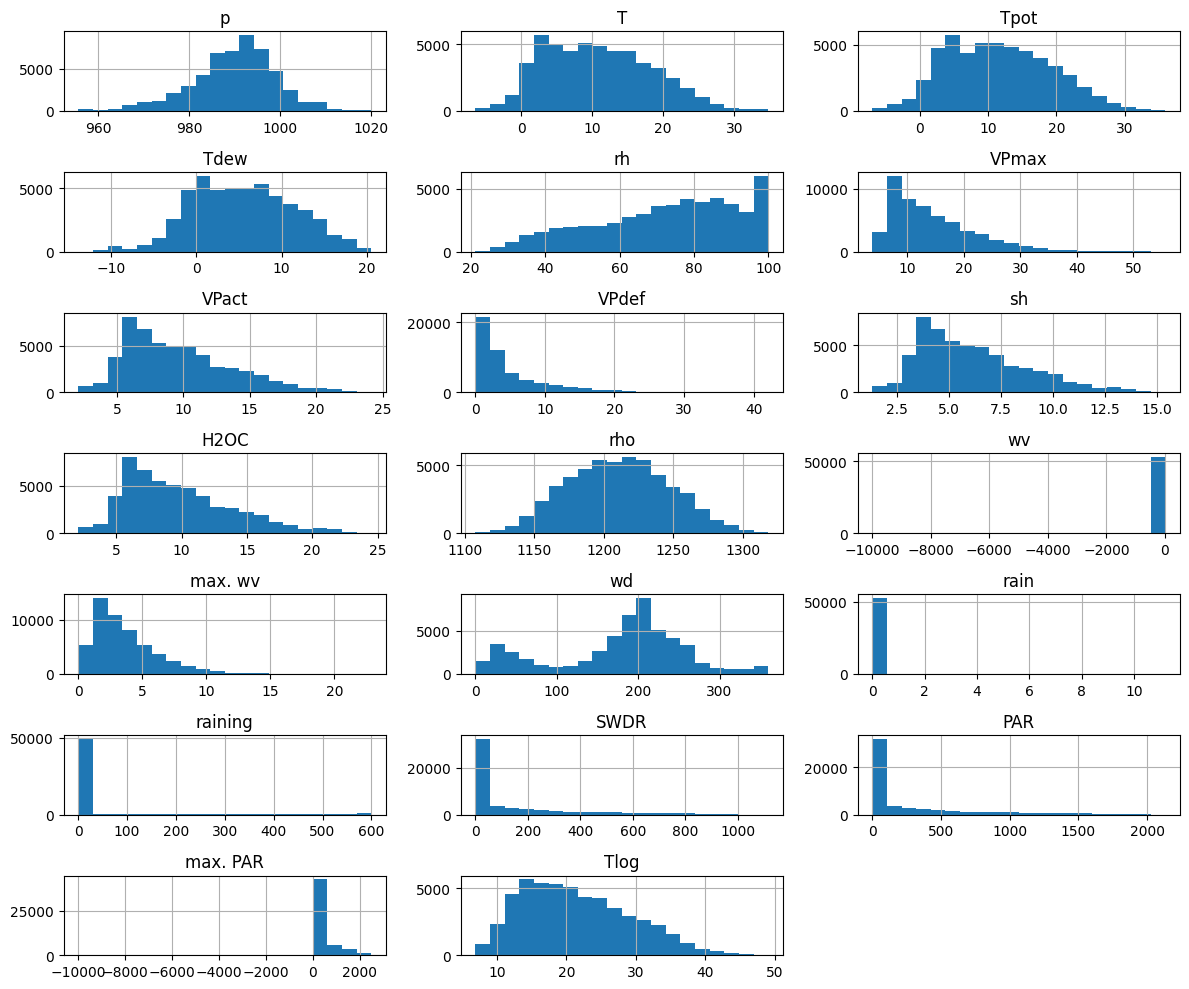

In [530]:
df.drop(columns=['date']).hist(figsize=(12, 10), bins=20, layout=(-1, 3))
plt.tight_layout()
plt.show()

Матрица корреляций

In [531]:
corr = df.drop(columns=['date']).corr()
corr.style.background_gradient(cmap='coolwarm')

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
p,1.000000,-0.127305,-0.223450,-0.207280,-0.068386,-0.098905,-0.183765,-0.002805,-0.200955,-0.201174,0.437434,-0.010172,-0.229759,-0.129084,-0.071890,-0.135033,0.073811,0.067915,0.048888,-0.082453
T,-0.127305,1.000000,0.995228,0.782740,-0.540784,0.967901,0.762860,0.779616,0.761550,0.761934,-0.946510,0.007514,0.109162,-0.061356,0.008448,-0.048777,0.448607,0.459806,0.399064,0.981562
Tpot,-0.223450,0.995228,1.000000,0.789478,-0.524880,0.961013,0.767773,0.766556,0.768193,0.768590,-0.973132,0.008397,0.130117,-0.047439,0.015404,-0.034742,0.433570,0.445155,0.387362,0.972736
Tdew,-0.207280,0.782740,0.789478,1.000000,0.087203,0.712665,0.977413,0.272064,0.976878,0.977256,-0.798148,0.000130,-0.110783,0.022842,0.069465,0.094311,0.104446,0.117344,0.106536,0.741963
rh,-0.068386,-0.540784,-0.524880,0.087203,1.000000,-0.561612,0.085528,-0.836007,0.086812,0.086729,0.440074,-0.012581,-0.347825,0.115019,0.087426,0.228862,-0.558295,-0.558661,-0.483217,-0.558603
VPmax,-0.098905,0.967901,0.961013,0.712665,-0.561612,1.000000,0.712554,0.860390,0.711273,0.711482,-0.900199,0.006312,0.095102,-0.068674,-0.001426,-0.062691,0.466474,0.478430,0.412244,0.962748
VPact,-0.183765,0.762860,0.767773,0.977413,0.085528,0.712554,1.000000,0.255506,0.999814,0.999816,-0.771779,-0.000390,-0.122343,0.013970,0.073675,0.089040,0.101192,0.113418,0.100975,0.727446
VPdef,-0.002805,0.779616,0.766556,0.272064,-0.836007,0.860390,0.255506,1.000000,0.253875,0.254162,-0.679846,0.008982,0.219911,-0.104771,-0.055481,-0.151059,0.569282,0.576877,0.494714,0.798241
sh,-0.200955,0.761550,0.768193,0.976878,0.086812,0.711273,0.999814,0.253875,1.000000,0.999997,-0.776002,-0.000211,-0.117849,0.016267,0.075156,0.091335,0.099126,0.111392,0.099406,0.725602
H2OC,-0.201174,0.761934,0.768590,0.977256,0.086729,0.711482,0.999816,0.254162,0.999997,1.000000,-0.776427,-0.000203,-0.117755,0.016316,0.075122,0.091395,0.099238,0.111511,0.099524,0.725934


"Роза ветров"

In [532]:
# ser = df.groupby('wd_name').count().p.to_frame()
# ser = ser.reset_index()
# sns.scatterplot(x=ser['wd_name'], y=ser.p)

Вычленим из datetime отдельные дни, месяцы, недели...

In [533]:
df.date = pd.to_datetime(df.date)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week'] = df['date'].dt.isocalendar().week
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute

Добавим в качестве признака направление ветра в румбах

In [534]:
directions = [
    'С', 'ССВ', 'СВ', 'ВСВ', 'В', 'ВЮВ', 'ЮВ', 'ЮЮВ',
    'Ю', 'ЮЮЗ', 'ЮЗ', 'ЗЮЗ', 'З', 'ЗСЗ', 'СЗ', 'ССЗ'
]

def degrees_to_direction(angle):
    normalized_angle = angle % 360  # Нормализация угла. Есть записи, где направление равно 360 и 0 градусов, чего быть не должно
    index = int((normalized_angle + 11.25) / 22.5) % 16
    return directions[index]

df['wd_name'] = df['wd'].apply(degrees_to_direction)

Посмотрим распределение направления ветра в зависимости от месяца

<Axes: xlabel='wd_name', ylabel='month'>

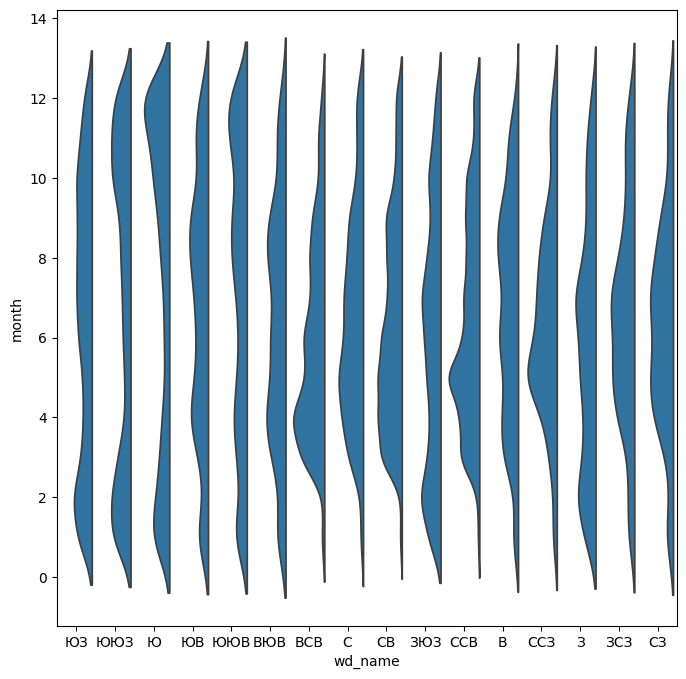

In [535]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.violinplot(data=df, x="wd_name", y="month",split=True, inner=None, ax=ax)

Можно сделать вывод, что южные ветра дуют преимущественно в начале и конце года, а северные - в середине

Применим дискретное преобразование Фурье для анализа спектра фукнции(временного ряда). Это может помочь выявить периодичность, закономерность в данных

In [536]:
SAMPLING_INTERVAL = 10  # минуты дельты записей
SAMPLES_PER_DAY = int((24*60)/SAMPLING_INTERVAL)  # 24ч * 60мин / 10мин = количестов записей за 1 день
SAMPLES_PER_WEEK = int((7*24*60)/SAMPLING_INTERVAL)
SAMPLES_PER_MONTH = int(((365/12)*24*60)/SAMPLING_INTERVAL)

In [537]:
def visualise_fft(series, feature_name, key):
    if key == 'month':
        samples = SAMPLES_PER_MONTH
    elif key == 'week':
        samples = SAMPLES_PER_WEEK
    else:
        samples = SAMPLES_PER_DAY

    n = len(series)
    y = series.values
    
    y_normalized = y - y.mean()     # Центрирование данных.
                                    # Избавление "засоряющего" спектр колебания на частоте 0Гц. Колебания на 0 частоте не изменяются со временем, при преобразовании Фурье будут иметь значения среднего по ряду.
    yf = fft(y_normalized)          # Применяя быстрое преобразование Фурье, получаем массив комплексных значений - информация о частотах спектра
    xf = fftfreq(n, d=1/samples)    # Возвращает массив - частота в циклах/ед.измерения

    amplitudes = (2 * np.abs(yf[:n//2]))/n      # Вычисление величины амплитуд, путем взятия модуля комплексного числа. Мнимая часть отвечает за сходство с синусом, а Re часть, за сходство с косинусом.
                                                # Взятие первой половины, поскольку, по ?теореме Найквиста?, можно выделить не более чем [(частота дискретизации)/2] частот без перекрытия частотами друг друга(aliasing)
                                                # Умножение на 2 для компенсации; деление на n для нормализации
    frequencies = xf[:n//2]
    
    # Поиск доминирующих частот в спектре
    idx = np.argsort(amplitudes)[::-1]
    top_freq = frequencies[idx[:5]]
    top_amp = amplitudes[idx[:5]]
    
    # График
    plt.figure(figsize=(12, 5))
    plt.plot(frequencies, amplitudes)
    plt.scatter(top_freq, top_amp, color='red')
    plt.title(f'Спектр признака {feature_name}')
    plt.xlabel('Частота Гц')
    plt.ylabel('Амплитуда')
    plt.xlim(0, 4)
    plt.grid()
    plt.show()
    
    print(f"\nДоминирующие частоты для {feature_name}:")
    for freq, amp in zip(top_freq, top_amp):
        if freq > 0:
            period = 1/freq
            print(f"{freq:.4f} Гц \t период: {period:.4f} {key} \t Амплитуда: {amp:.4f}")

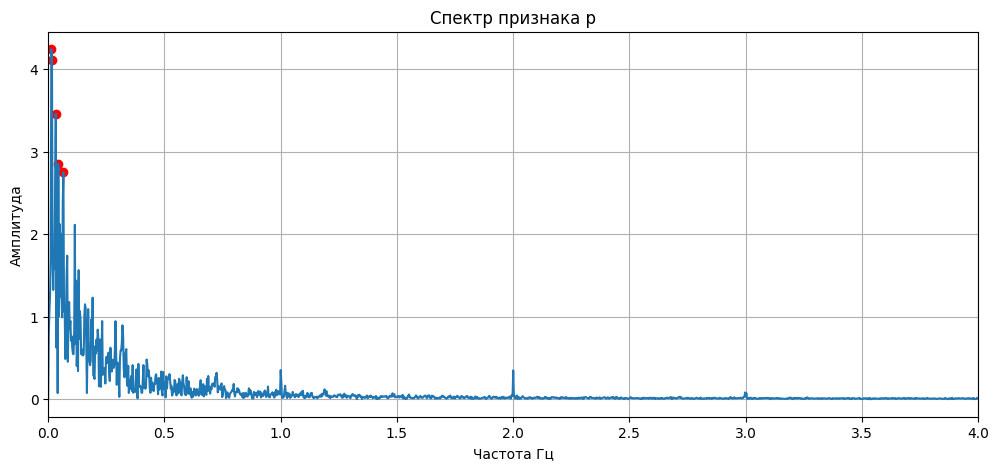


Доминирующие частоты для p:
0.0137 Гц 	 период: 73.1889 day 	 Амплитуда: 4.2428
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 4.1105
0.0328 Гц 	 период: 30.4954 day 	 Амплитуда: 3.4602
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 2.8518
0.0656 Гц 	 период: 15.2477 day 	 Амплитуда: 2.7506


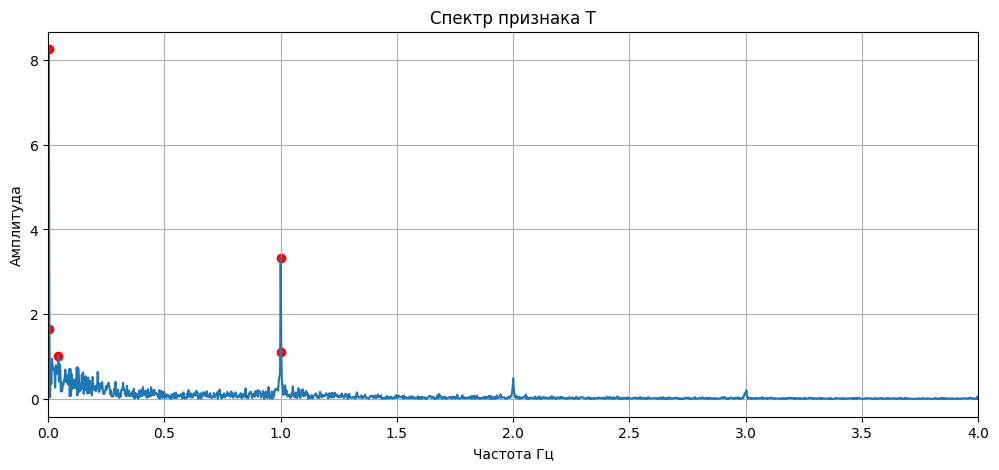


Доминирующие частоты для T:
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 8.2459
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 3.3385
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 1.6433
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 1.1141
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 1.0296


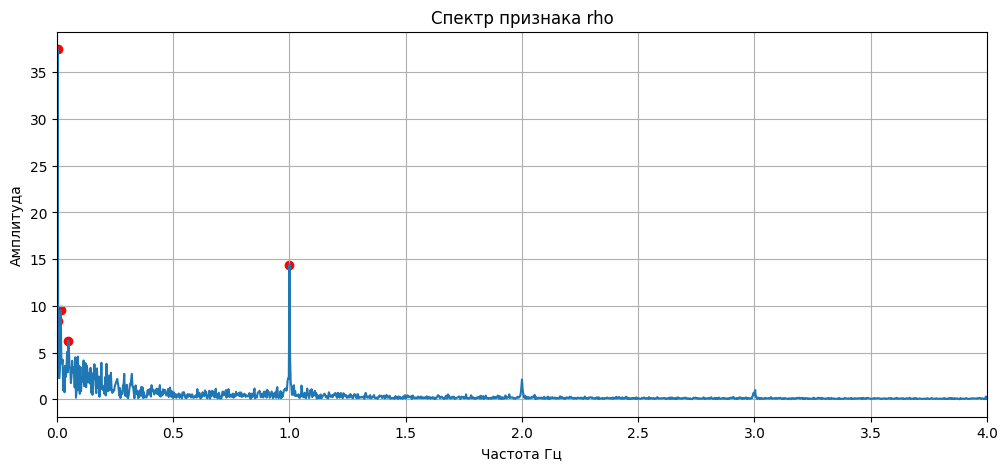


Доминирующие частоты для rho:
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 37.4701
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 14.4055
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 9.5135
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 8.3230
0.0492 Гц 	 период: 20.3302 day 	 Амплитуда: 6.2678


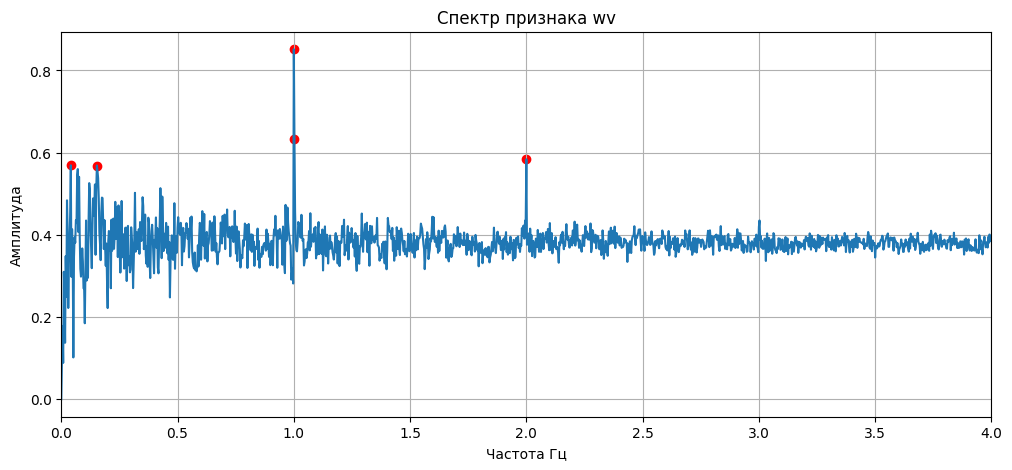


Доминирующие частоты для wv:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 0.8515
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 0.6321
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 0.5838
0.0410 Гц 	 период: 24.3963 day 	 Амплитуда: 0.5691
0.1530 Гц 	 период: 6.5347 day 	 Амплитуда: 0.5686


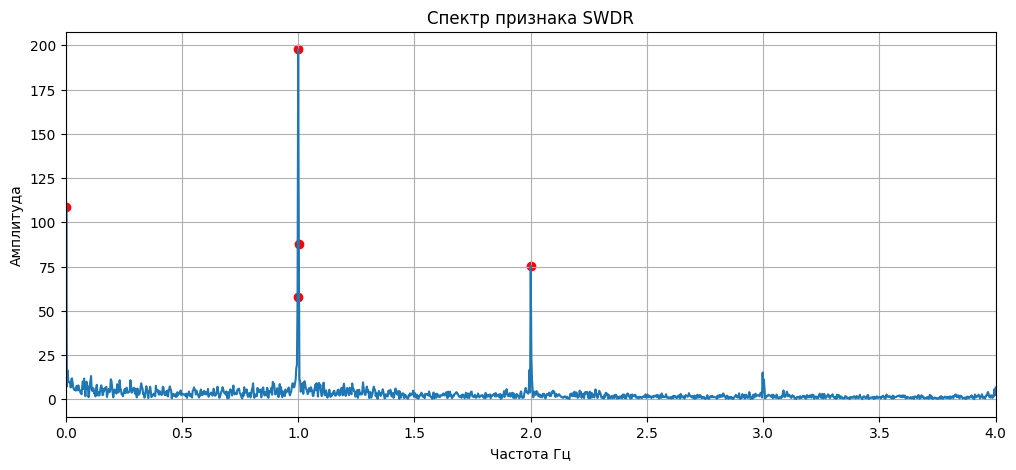


Доминирующие частоты для SWDR:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 197.8297
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 108.8701
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 87.9288
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 75.5589
0.9974 Гц 	 период: 1.0026 day 	 Амплитуда: 57.5561


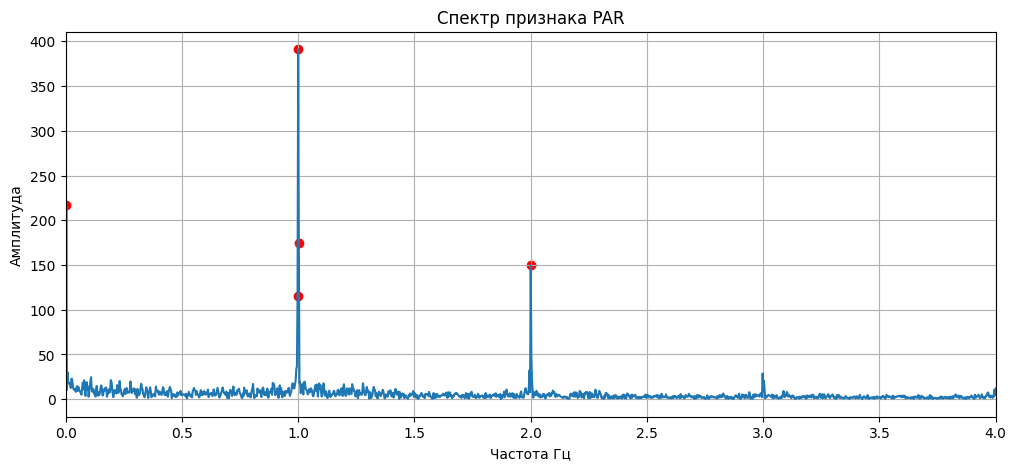


Доминирующие частоты для PAR:
1.0002 Гц 	 период: 0.9998 day 	 Амплитуда: 391.1192
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 216.9351
1.0029 Гц 	 период: 0.9971 day 	 Амплитуда: 174.5855
2.0003 Гц 	 период: 0.4999 day 	 Амплитуда: 149.6320
0.9974 Гц 	 период: 1.0026 day 	 Амплитуда: 115.5954


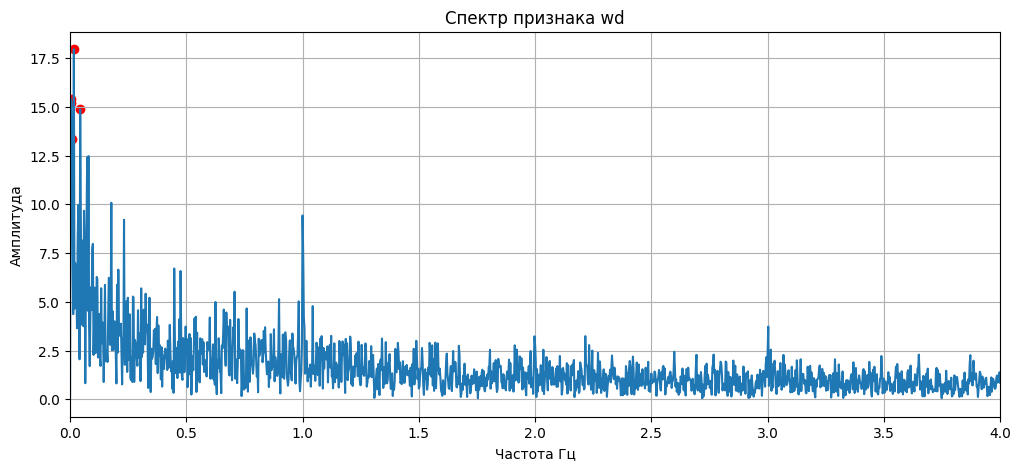


Доминирующие частоты для wd:
0.0164 Гц 	 период: 60.9907 day 	 Амплитуда: 17.9611
0.0027 Гц 	 период: 365.9444 day 	 Амплитуда: 15.4047
0.0055 Гц 	 период: 182.9722 day 	 Амплитуда: 15.2085
0.0437 Гц 	 период: 22.8715 day 	 Амплитуда: 14.8739
0.0082 Гц 	 период: 121.9815 day 	 Амплитуда: 13.3329


In [538]:
# Признаки, которые, как мне кажется, фундаментальны(не выражаются через другие)
valid_cols = ['p', 'T', 'rho', 'wv', 'SWDR', 'PAR', 'wd']
for feature in valid_cols:
    visualise_fft(df[feature], feature, 'day')

В результате анализа спектров, можно сделать выводы:
1. Выражена цикличность в 1 день, 60 дней, 180 дней
2. Для всех признаков присущ период в 365 дней, поскольку график данных за год хорошо апроксимируется синусоидой.

In [539]:
# В таком виде добавлять признаки нельзя, поскольку всегда получается константа, смысла от этого нет. Нужно добавть что то типа скользящего окна по записям
def create_feature_fft(data, feature_name):
    series = data[feature]
    y = series.values
    n = len(y)

    yf = fft(y - y.mean())

    # Для суток
    freqs = fftfreq(n, d=1/SAMPLES_PER_DAY)
    idx = np.argmin(np.abs(freqs - 1))
    data[f'{feature_name}_daily_amplitude'] = (2 * np.abs(yf[idx]))/n
    data[f'{feature_name}_daily_phase'] = np.angle(yf[idx])
    
    # Для недель
    freqs = fftfreq(n, d=1/SAMPLES_PER_WEEK)
    idx = np.argmin(np.abs(freqs - 1/365.25))
    data[f'{feature_name}_weekly_amp'] = (2 * np.abs(yf[idx]))/n
    data[f'{feature_name}_weekly_phase'] = np.angle(yf[idx])

    # Для месяца
    freqs = fftfreq(n, d=1/SAMPLES_PER_MONTH)
    idx = np.argmin(np.abs(freqs - 1/365.25))
    data[f'{feature_name}_monthly_amp'] = (2 * np.abs(yf[idx]))/n
    data[f'{feature_name}_monthly_phase'] = np.angle(yf[idx])
    
    return data

# for feature in valid_cols:
#     df = create_feature_fft(df, feature)

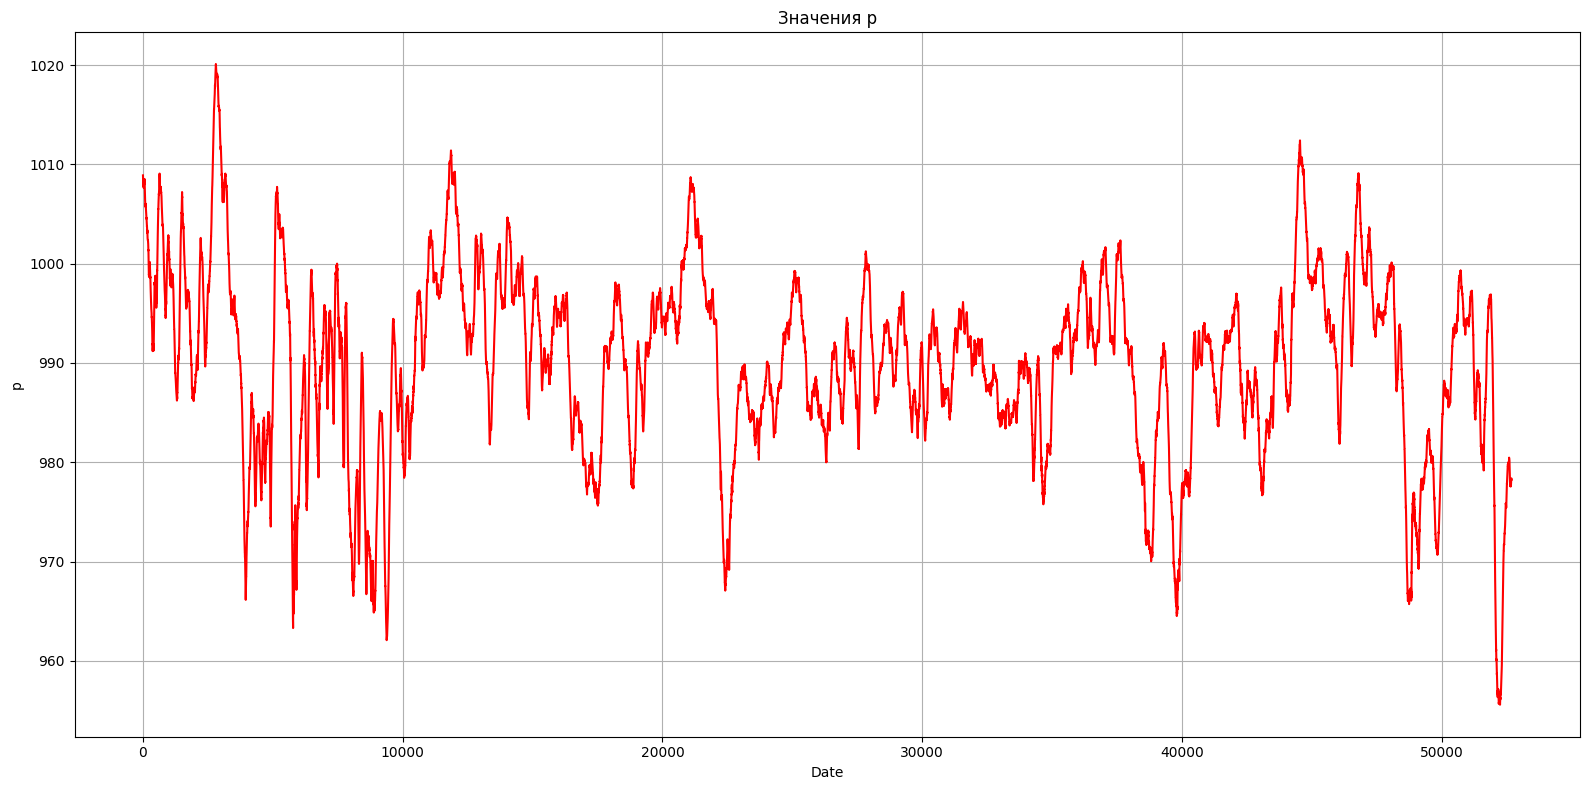

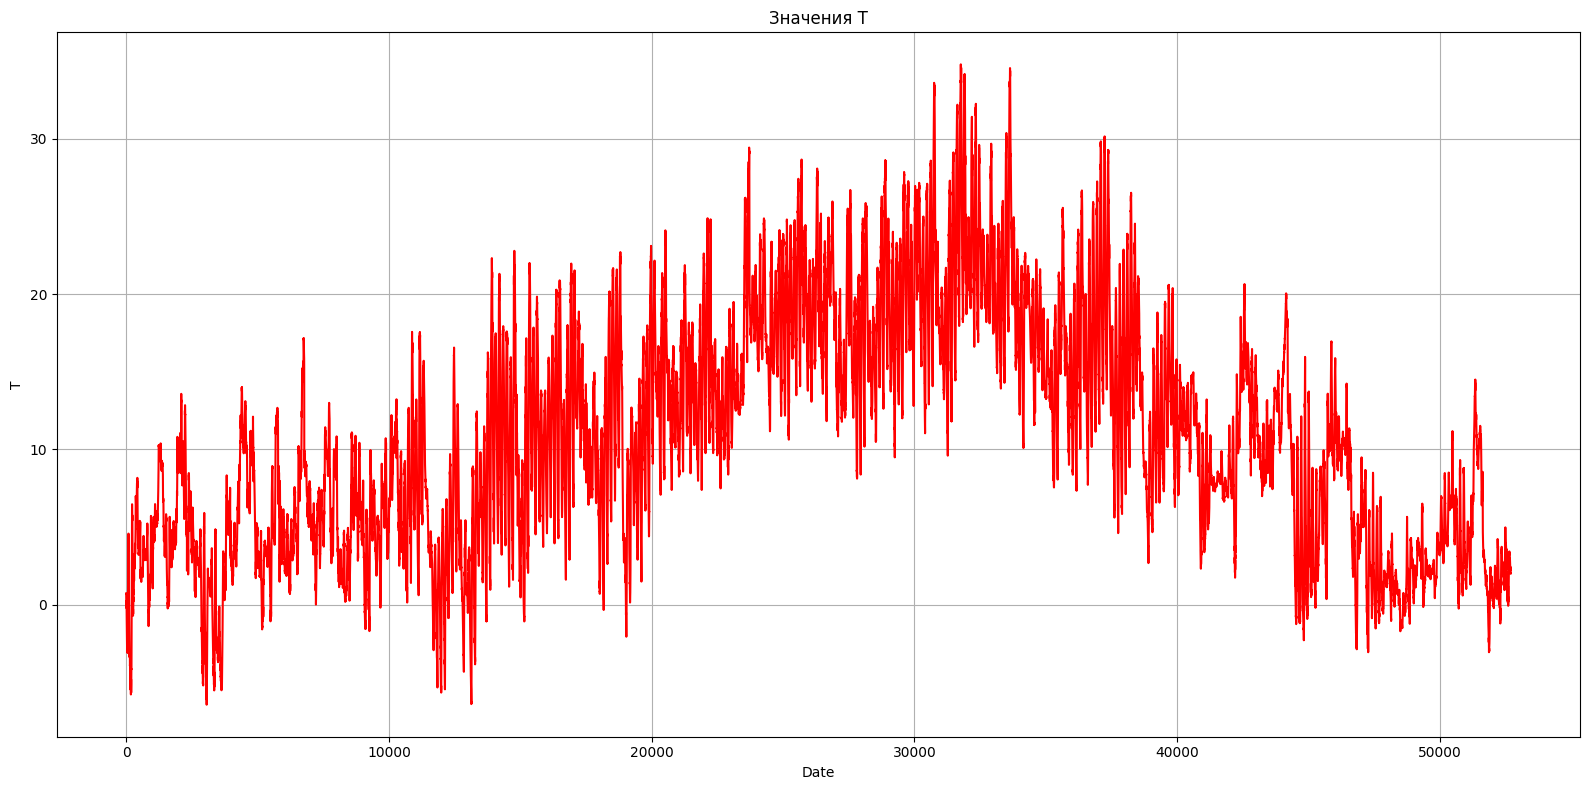

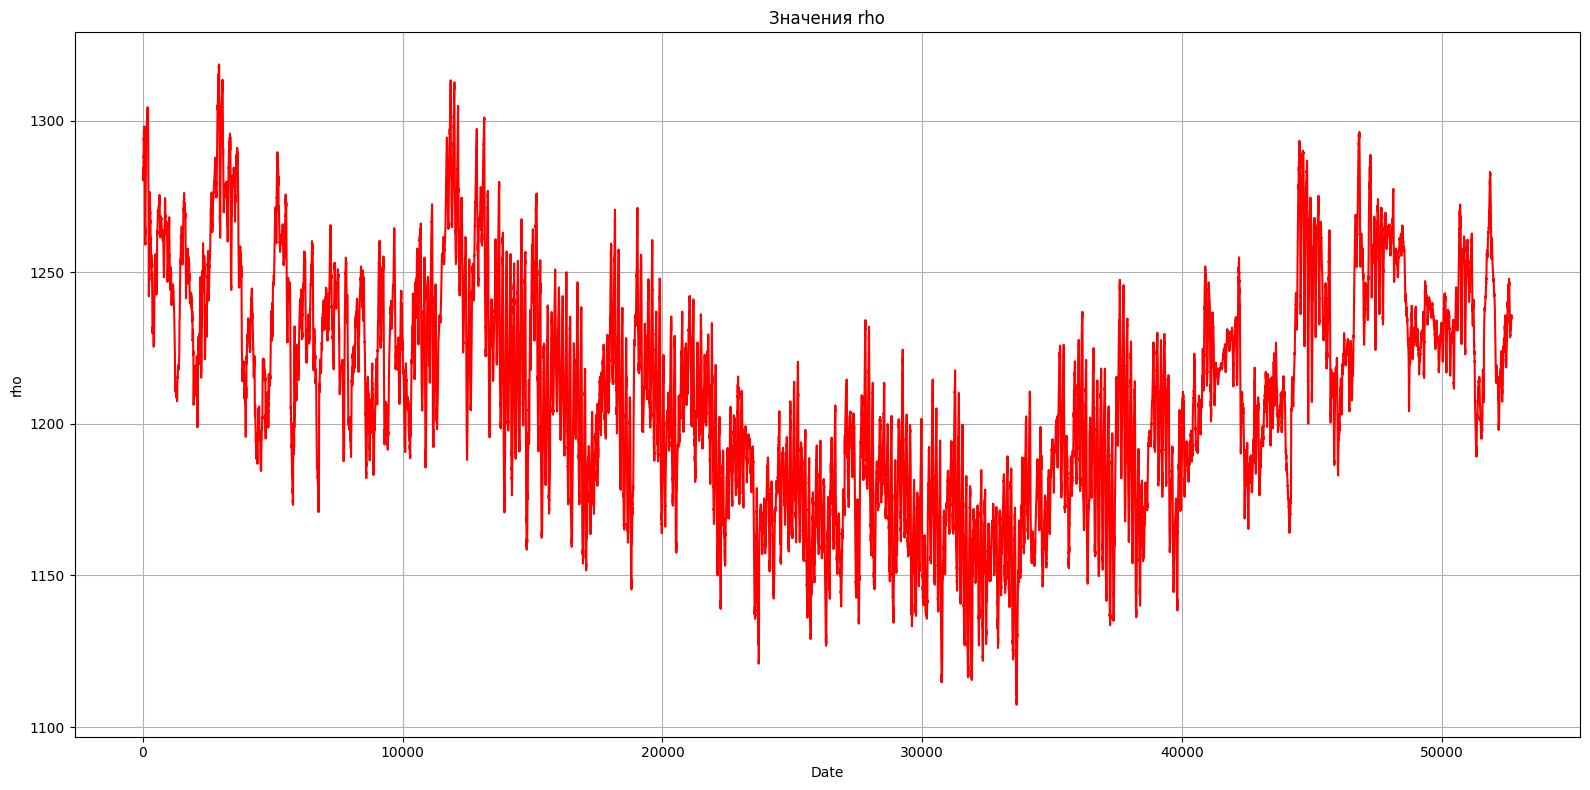

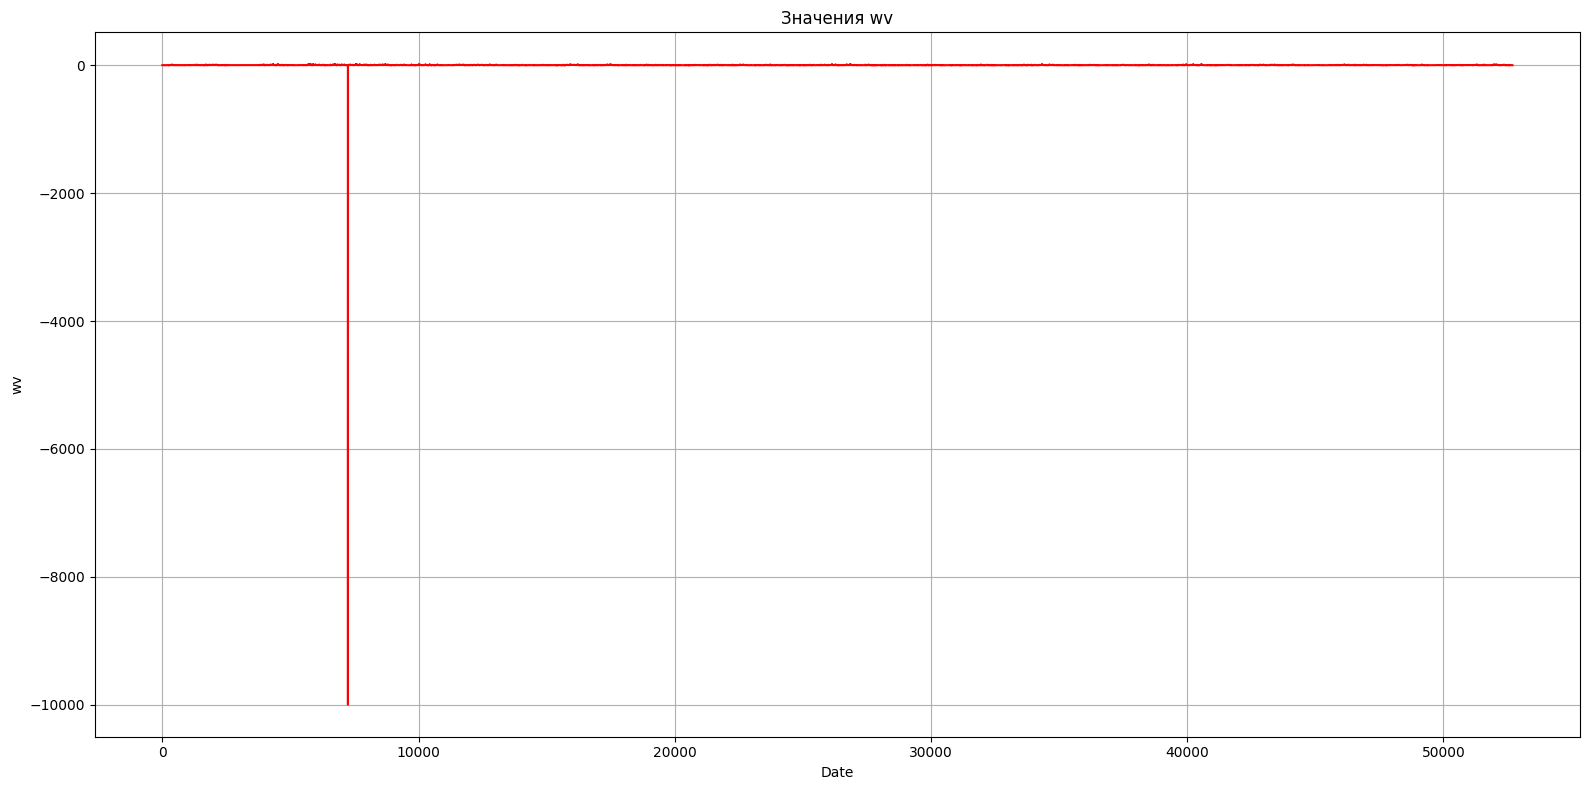

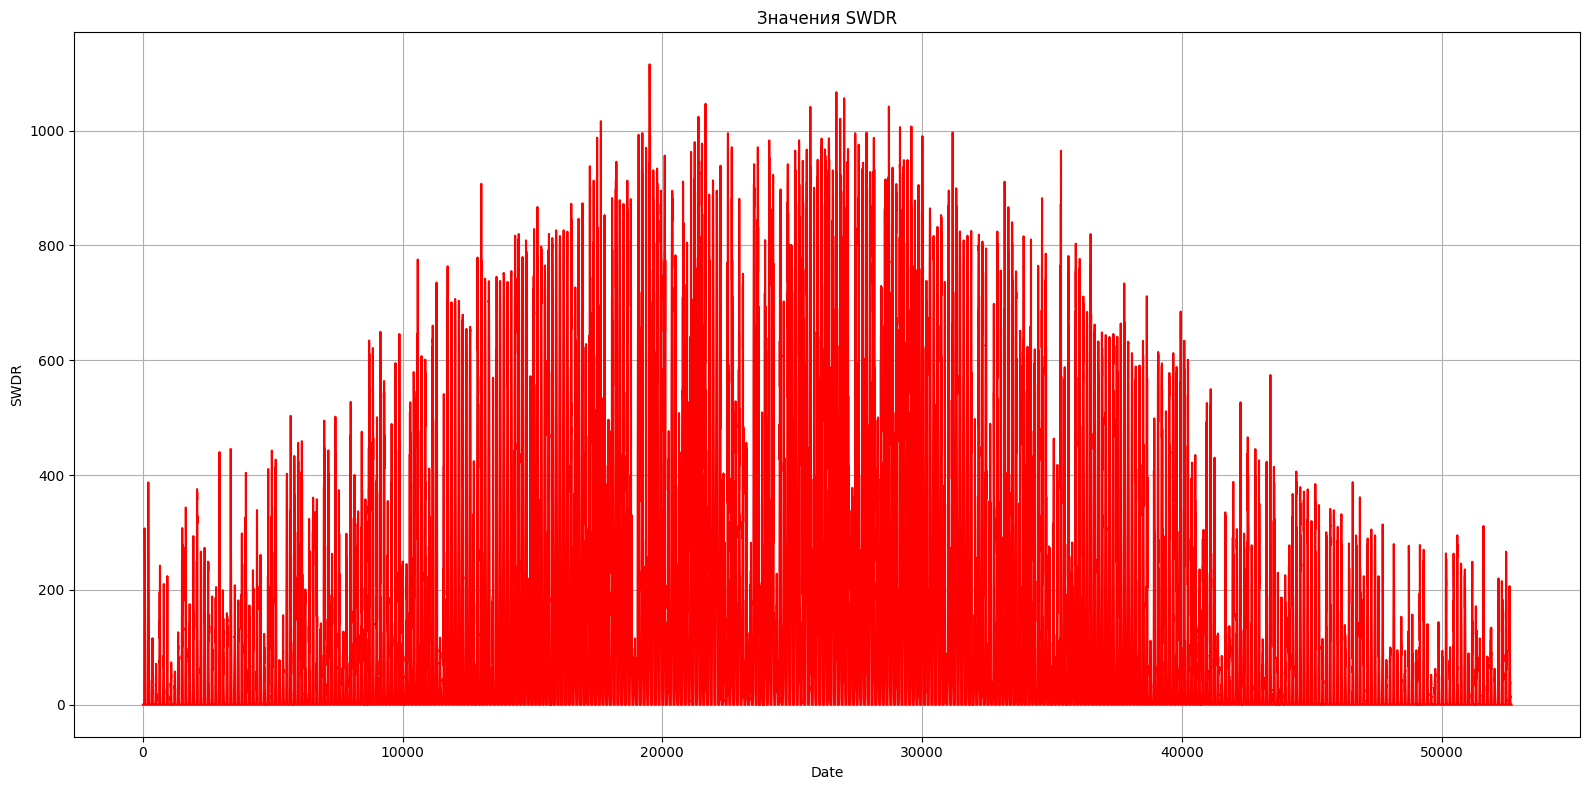

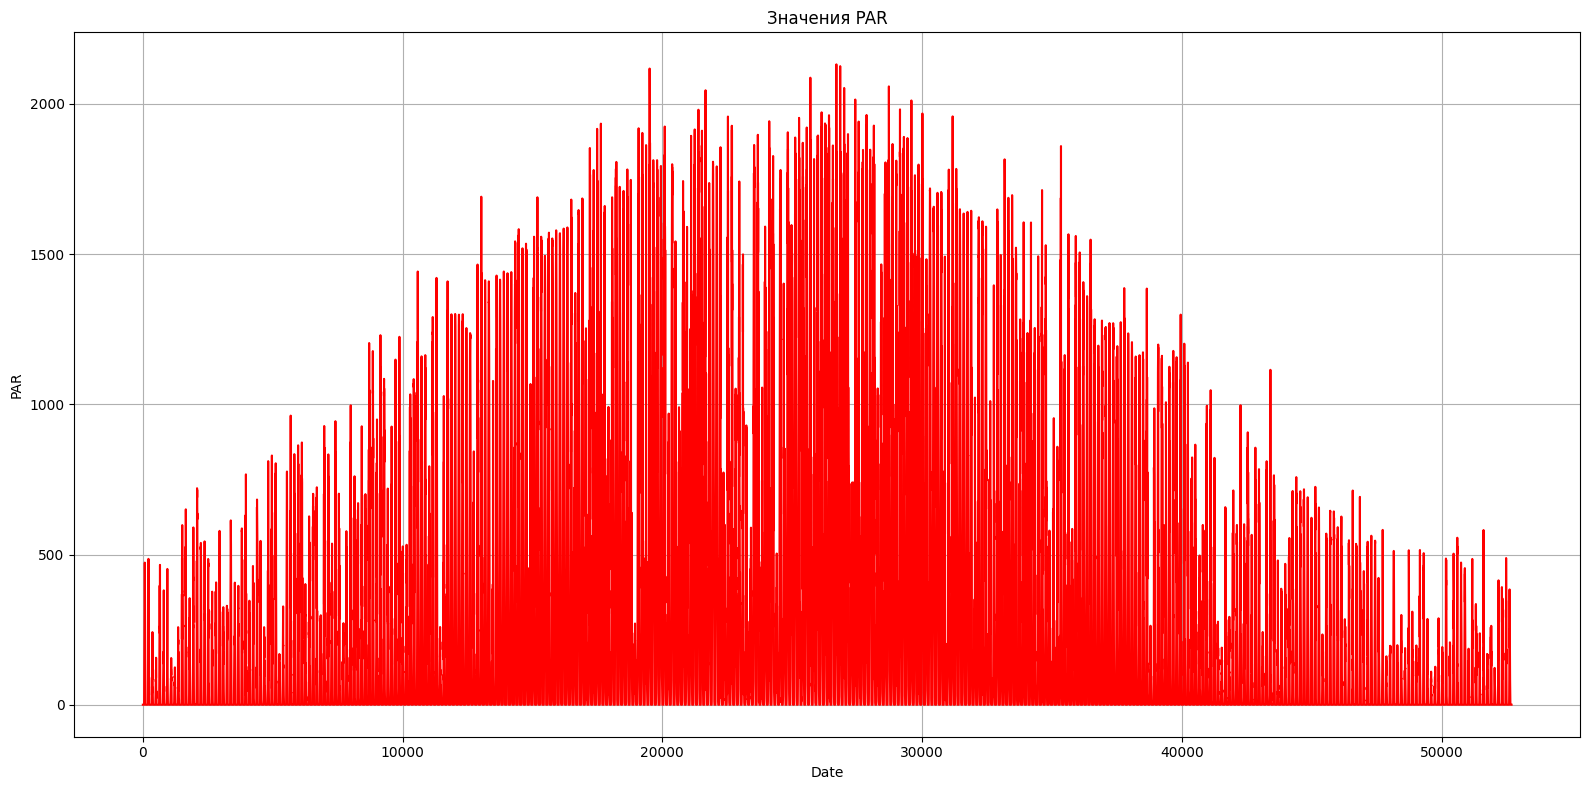

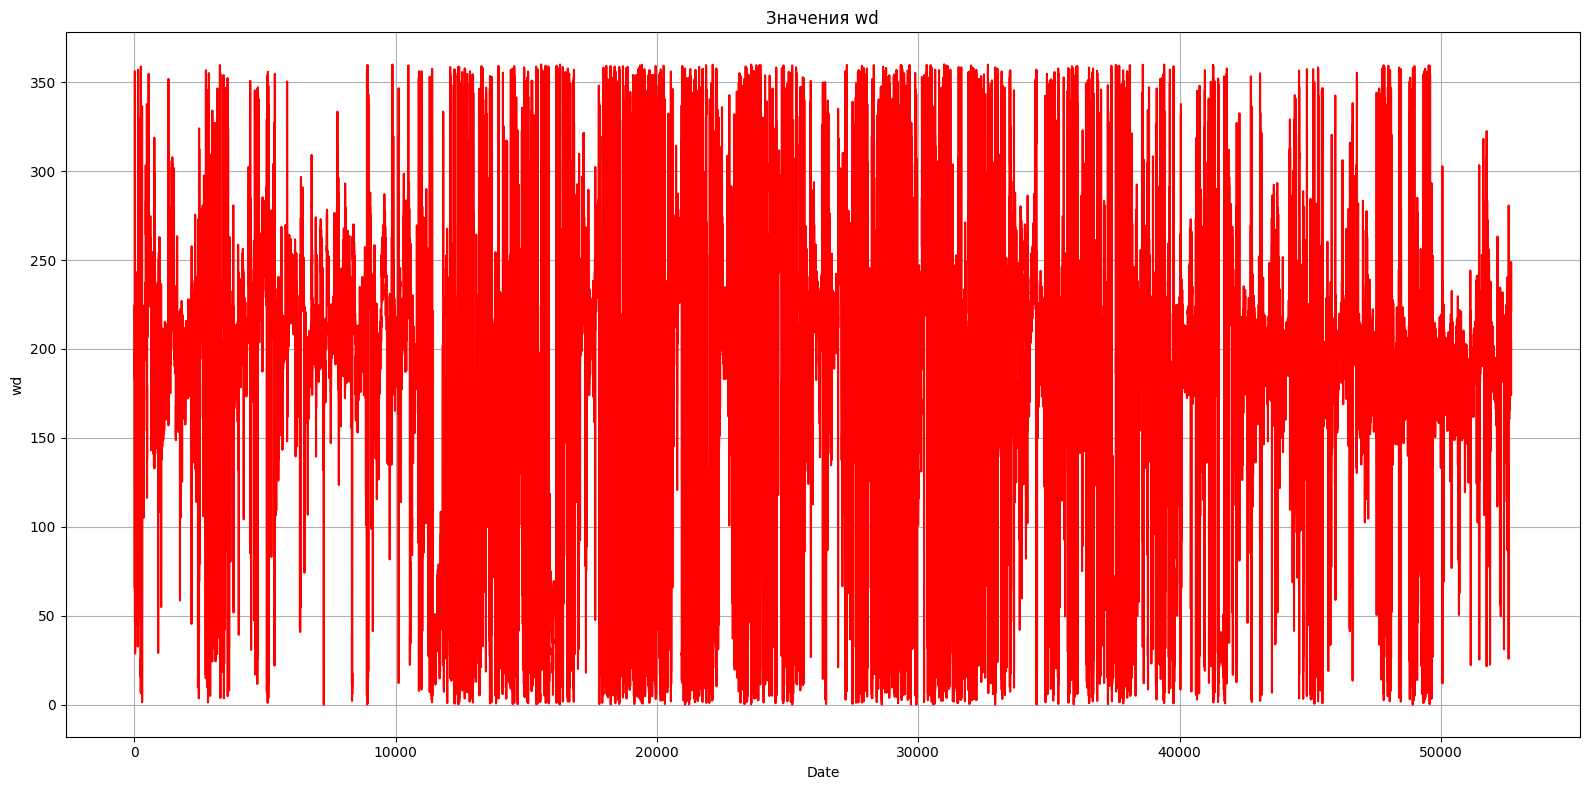

In [540]:
features_to_viz = valid_cols

for feature in features_to_viz:
    plt.figure(figsize=(16, 8))
    plt.plot(df[feature], linestyle='-', color='red')

    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.grid(True)
    plt.title(f'Значения {feature}')

    plt.tight_layout()
    plt.show()

# Preprocessing

Значения T и Tlog очень сильно скореллированы. Судя по описанию - это температура с разных дачиков, уберем один из признаков.

In [541]:
df.drop(columns='Tlog', inplace=True)

Можно заметить, что признаки wv (скорость ветра) и max.Par (солнечная радиация) имеют отрицательные значения, такого быть не должно. К счастью, записей с такими значениями не очень много, всего около 30, заполним их ближайшим предшествуюшим значением

In [542]:
df.loc[(df['wv'] < 0), 'wv'] = np.nan
df.loc[(df['max. PAR'] < 0), 'max. PAR'] = np.nan
df = df.ffill()

Признак "время года".\
1 = зима, 2 = весна...

In [543]:
df['season'] = df['month'].apply(lambda x: (x//3)+1 if x != 12 else 1)
df = pd.get_dummies(df, columns=['season'])

Для грамотного обучения, анализа необходим другой подход для определения направления ветра. По факту между 0 и 358 градусами разница незначительная, но для модели - колоссальная

Cкользящее окно для определения среднего значения для некоторых признаков

In [544]:
for feature in valid_cols:
    df[f'{feature}_mean_hour'] = df[feature].rolling(window=6,min_periods=1).mean()

    df[f'{feature}_mean_day'] = df[feature].rolling(window=SAMPLES_PER_DAY,min_periods=1).mean()

    df[f'{feature}_mean_week'] = df[feature].rolling(window=SAMPLES_PER_WEEK,min_periods=1).mean()

    df[f'{feature}_mean_month'] = df[feature].rolling(window=SAMPLES_PER_MONTH,min_periods=1).mean()

In [545]:
encoder = OrdinalEncoder()
df['wd_name_encoded'] = encoder.fit_transform(df[['wd_name']]).astype(int)

# Запись в файл

In [546]:
df.to_csv('preprocesed_df.csv', index=False)

# Разбиение на выборки

In [547]:
df = pd.read_csv('preprocesed_df.csv')

In [548]:
df = df.sort_values('date')
y = df['wd_name_encoded']
X = df.drop(columns=['wd', 'wd_name', 'wd_name_encoded', 'date'], axis=1)

X_t, X_validation, y_t, y_validation = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.15, shuffle=True)

In [549]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_validation)

# Предсказания

Будем предсказывать направление ветра в румбах

In [550]:
# clf = CatBoostRegressor(iterations=1200, learning_rate=0.01, depth=10, random_state=42, task_type="GPU", devices='0')
# clf = CatBoostRegressor(iterations=1200, learning_rate=0.01, depth=10, random_state=42)
clf = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1, n_estimators=200)

In [551]:
#clf.fit(X_train_scaled, y_train, verbose=20, eval_set=(X_test_scaled, y_test), plot=True)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=100, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [552]:
clf.score(X_train_scaled, y_train)

1.0

Выведем предсказания на графике и посчитаем метрики

In [553]:
prediction = clf.predict(X_test_scaled)
prediction = prediction.astype(int)

In [554]:
# plt.figure(figsize=(16, 8))
# plt.plot(y_test.index, y_test, linestyle='-', color='red')
# plt.plot(y_test.index, prediction, linestyle='-', color='blue')

# plt.xlabel('Date')
# plt.ylabel('Predictions on Temperature')
# plt.legend(["true", "prediction"])
# plt.grid(True)

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

<Axes: >

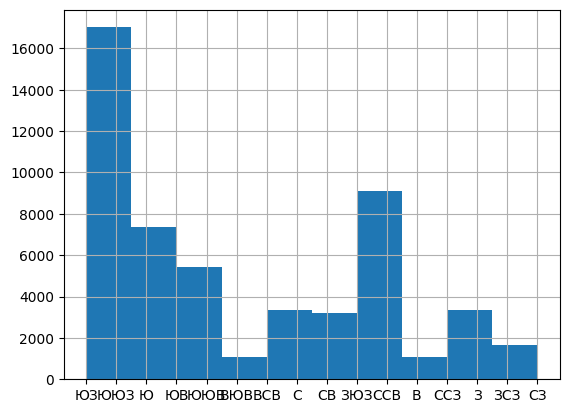

In [555]:
df['wd_name'].hist()

In [556]:
target_names = [
    'С', 'ССВ', 'СВ', 'ВСВ', 'В', 'ВЮВ', 'ЮВ', 'ЮЮВ',
    'Ю', 'ЮЮЗ', 'ЮЗ', 'ЗЮЗ', 'З', 'ЗСЗ', 'СЗ', 'ССЗ'
]
print(classification_report(y_test, prediction, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

           С       0.31      0.27      0.29       146
         ССВ       0.44      0.43      0.43       272
          СВ       0.18      0.16      0.17       145
         ВСВ       0.47      0.43      0.45       354
           В       0.22      0.21      0.21       123
         ВЮВ       0.61      0.68      0.64       769
          ЮВ       0.35      0.28      0.31       212
         ЮЮВ       0.49      0.54      0.51       457
           Ю       0.21      0.14      0.17       104
         ЮЮЗ       0.61      0.62      0.61       558
          ЮЗ       0.26      0.19      0.22       135
         ЗЮЗ       0.53      0.53      0.53       863
           З       0.33      0.26      0.29       266
         ЗСЗ       0.55      0.54      0.54       891
          СЗ       0.35      0.37      0.36       441
         ССЗ       0.64      0.69      0.66      1378

    accuracy                           0.52      7114
   macro avg       0.41   

Предсказания получились, откровенно, не очень

# Использование продвинутых алгоритмов

In [4]:
#import torch
from torch import nn

ModuleNotFoundError: No module named 'torch'

# Итоговый результат на валидационной выборке

In [557]:
prediction = clf.predict(X_valid_scaled)
prediction = prediction.astype(int)

In [558]:
print(classification_report(y_validation, prediction, target_names=target_names, zero_division=0))

              precision    recall  f1-score   support

           С       0.00      0.00      0.00        57
         ССВ       0.00      0.00      0.00        82
          СВ       0.00      0.00      0.00        58
         ВСВ       0.36      0.05      0.08        86
           В       0.00      0.00      0.00        41
         ВЮВ       0.62      0.56      0.58       205
          ЮВ       0.00      0.00      0.00        92
         ЮЮВ       0.29      0.01      0.02       209
           Ю       0.00      0.00      0.00        30
         ЮЮЗ       0.00      0.00      0.00       214
          ЮЗ       0.00      0.00      0.00        49
         ЗЮЗ       0.45      0.59      0.51      1734
           З       0.09      0.01      0.01       160
         ЗСЗ       0.28      0.15      0.19       405
          СЗ       0.15      0.04      0.07       561
         ССЗ       0.43      0.79      0.55      1287

    accuracy                           0.43      5270
   macro avg       0.17   